## Check blocks in provided range and find new tokens being initiated

In [ ]:
import os
from dotenv import load_dotenv 
import json
from utils import *
from web3 import Web3
import pandas as pd
from pprint import pprint
from utils import *
from tqdm import tqdm
from datetime import datetime
import time

# Get the config file
configObj = ConfigManager("config.json")
appInfo, configData = configObj.load_config()
nodeUrl = appInfo["alchemy_url"]+appInfo["alchemy_key"]

# Checking the database state
print("Checking database integrity ...")
db = dbUtils(user = "postgres", password = "1234", host  = "localhost", port =  "5432")
# See if database exists
if db.database_exists("screenerDB"):
    if not db.table_exists("screenerDB", "tokens"):
        print("Creating table 'tokens' in the database 'screenerDB'")
        # Cursor
        db._connect_to_db("screenerDB")
        con = db._conn
        cur = con.cursor()
        
        # Make a table for the new tokens
        cur.execute("""
            CREATE TABLE IF NOT EXISTS tokens (
                id SERIAL PRIMARY KEY,
                address VARCHAR(255),
                name VARCHAR(255),
                symbol VARCHAR(255),
                chain_name VARCHAR(255),
                decimals INT,
                inception_time BIGINT,
                inception_block BIGINT,
                total_supply VARCHAR(255)
            )
        """)
        
        con.commit()
        
        # close the connection
        con.close()
    else:
        pass
else:
    raise Exception(f"Database doesn't exist. First create the database with the name 'screenerDB'")

# Make the ETH blockchain handler
web3 = Web3(Web3.HTTPProvider(nodeUrl))
handler = ETH_Handler(web3)

latest_block = handler.get_latest_block()

# True only if the config file is new.
if (configData['latest_block_checked'] == -1):
    configData['latest_block_checked'] = latest_block

print(f"{latest_block['number'] - configData['latest_block_checked']} blocks to check")

nonTokens = pd.DataFrame(columns=['address'])

try:
    # Go through past blocks to find conteract creation events
    for i in tqdm(range(configData['latest_block_checked'], latest_block['number']), total=latest_block['number'] - configData['latest_block_checked']):
        block = web3.eth.get_block(i, True)
        for tx in block.transactions:
            if tx["to"] == None:
                tx_receipt = web3.eth.get_transaction_receipt(tx['hash'])
                contract_address = tx_receipt['contractAddress']
                contract_code = web3.eth.get_code(contract_address)
                if contract_code != '0x':
                    _details = handler.get_token_details(contract_address)

                    if _details != None:
                        if _details["name"] != "-":
                            _data = {
                                'address': _details["address"],
                                'name': _details["name"],
                                'symbol': _details["symbol"],
                                'chain_name': "Ethereum",
                                'decimals': _details["decimals"],
                                'inception_time': datetime.now().timestamp(),
                                'inception_block': i,
                                'total_supply': str(_details["total_supply"])
                            }
                            state, _ = db.insert_row(appInfo["database_name"], "tokens", _data)
                            
                            # Raise an error if couldn't add to the database 
                            if not state:
                                raise Exception(f"Error in inserting token {contract_address} in the database")
                        else:
                            # DELETE
                            nonTokens = pd.concat([nonTokens, pd.DataFrame([contract_address], columns=['address'])])
                            pass
        configData['latest_block_checked'] = i
        configObj.save_config(configData)
        nonTokens.to_csv("nonTokens.csv") # DELETE

        time.sleep(0.02)
    
    # Update the latest block checked
    configData['latest_block_checked'] = i
    configObj.save_config(configData)
    print("Database updated successfully")
    
    # DELETE
    nonTokens.to_csv("nonTokens.csv")
    
except Exception as e:
    configData['latest_block_checked'] =  i
    configObj.save_config(configData)
    print(f"Error in block {i}")
    print(f"Error: {e}")

## Download timestamp of blocks on ethereum and save them to a csv file 

In [ ]:
import os, csv
from dotenv import load_dotenv 
import json
from utils import *
from web3 import Web3
import pandas as pd
from pprint import pprint
from utils import *
from tqdm import tqdm
from datetime import datetime
import time
from pathlib import Path

# Get the config file
configObj = ConfigManager("config.json")
appInfo, configData = configObj.load_config()
nodeUrl = appInfo["alchemy_url"]+appInfo["alchemy_key"]

def __getBlockTimestamp(blockNumber:int, web3Obj:Web3):
    """
    Gets an ethereum block and returns its timestamp and datetime as a dictionary 
    """
    __block = web3Obj.eth.get_block(blockNumber, False)
    return {
        "block": blockNumber, 
        "timestamp": __block["timestamp"], 
        "datetime": datetime.fromtimestamp(__block["timestamp"])
        }
    

def __getFiles(path:str):
    """
    Gets the CSV files in a folder
    
    Returns:
        A list of lists [[start block - end block]]
        A dictionary with smallest block number and its respective file name
        A dictionary with oldest block number and its respective file name
    """
    files = os.listdir(path)
    result = []
    __maxNumber = 0
    __maxNumber_file = ""
    __minNumber = 99999999999
    __minNumber_file = ""
    
    for file in files:
        if file.endswith('.csv'):
            parts = file.split('-')
            if len(parts) == 2:
                x = int(parts[0])
                m = int(parts[1].replace('.csv', ''))
                result.append([x, m])
                
                if __maxNumber < m: __maxNumber = m; __maxNumber_file = file
                if x < __minNumber: __minNumber = x; __minNumber_file = file
    
    return result, {"block_number":__minNumber,"file":__minNumber_file},{"block_number":__maxNumber,"file":__maxNumber_file}

def __makeCSV(path,startBlockNumber,endBlockNumber,web3, reverse = False):
    """
    Makes a fresh csv file and add blocks to it.
    
    Returns:
        Newly made file's name.
    """
    data = [
        ['block', 'timestamp', 'datetime'],
    ]
    if startBlockNumber < endBlockNumber:
        for i in range(startBlockNumber,endBlockNumber+1):
            __tmp = __getBlockTimestamp(i,web3)
            data.append([__tmp["block"], __tmp["timestamp"], __tmp["datetime"]])
    
    
    if reverse:
        data.reverse()
        data.insert(0, data.pop())
        
    with open(os.path.join(path,f"{startBlockNumber}-{endBlockNumber}.csv"), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        f.close()
        return f"{startBlockNumber}-{endBlockNumber}.csv"

def getBlockTimestamps(path:str, direction:str, web3Obj:Web3):
    """
    Gets block timestamps ands saves them in a csv file in passed path.
    Each CSV file contains ethereum block numbers, timestamps and datetimes. Blocks 
    get older as we move down the csv file.
    
    """
    
    # Defining the super parameters
    __Default_Start_Block = 21500000 # The first file's starting block (If there are no files in path)
    __Batch_length = 100000 # The amount of blocks each csv file can contain
    __Target_File = "" # The file which newly downloaded blocks are gonna be added to
    __Save_Batch_Length = 4000 # Save blocks in the csv file batches of this length
    __STOP = False # Weather to stop the downloading process
    __STOP_Sub_Batch = False # For checking i with latest block number to see if we have reached the most recent block
    
    # Get previously saved csv files
    if os.path.exists(path):
        
        # Get previous files
        lstFiles = __getFiles(path)
        
        if len(lstFiles[0]) != 0:
            __n1 = lstFiles[1]['block_number']
            __n2 = lstFiles[2]['block_number']
            print(f"Found {len(lstFiles[0])} records. Oldest block: {__n1}, most recent block: {__n2}")
        else:
            print(f"No files exist in the directory, making teh first file. Starting from block {__Default_Start_Block}")
            __makeCSV(path,__Default_Start_Block,__Default_Start_Block+1,web3Obj)
            __n1 = __Default_Start_Block
            __n2 = __Default_Start_Block+1
            lstFiles = __getFiles(path)
                
        # Set the starting block parameter
        if direction == "forward":
            
            # Get the target csv file to save the block data
            if lstFiles[2]["block_number"] % __Batch_length != __Batch_length - 1:
                __Target_File = os.path.join(path, lstFiles[2]["file"])
                __tmp = lstFiles[2]["block_number"]
                print(f"Catching up with latest block. Approx, {web3Obj.eth.block_number - __tmp} blocks to chatch up with ...")
            else:
                # Happens when the most recent file is full
                print(f"Most recent file is full. Making a new file for blocks bigger than {__n2}")
                __name = __makeCSV(path,lstFiles[2]["block_number"]+1,lstFiles[2]["block_number"]+2,web3Obj)
                __Target_File = os.path.join(path, __name)
            
            # First and Last block to catch
            __Download_Start_Block = int(os.path.basename(__Target_File).replace(".csv","").split("-")[1])+1
            __Download_End_Block = int(os.path.basename(__Target_File).replace(".csv","").split("-")[0]) + __Batch_length - 1
            
            while not __STOP:
                print(f"Downloading blocks {__Download_Start_Block} to {__Download_End_Block}")
                for batch in range(__Download_Start_Block,__Download_End_Block+1,__Save_Batch_Length):    
                    # Open the target file
                    with open(__Target_File, 'a', newline='') as f:
                        __data = []
                        writer = csv.writer(f)
                        
                        # See if the current sub-batch range has the latest block in it
                        if batch <= web3Obj.eth.block_number and web3Obj.eth.block_number <= __Download_End_Block:
                            __STOP = True
                            __STOP_Sub_Batch = True
                        
                        for i in tqdm(range(batch, min(batch + __Save_Batch_Length, __Download_End_Block+1))):
                            __tmp = __getBlockTimestamp(i,web3)
                            __data.append([__tmp["block"], __tmp["timestamp"], __tmp["datetime"]])
                            
                            # Is true only if the current sub-range range(batch, min(batch + __Save_Batch_Length, __Download_End_Block+1))
                            # contains the latest block number
                            if __STOP_Sub_Batch:
                                if i == web3Obj.eth.block_number: 
                                    print(f"Caught up with latest block {i}")
                                    break
                        
                        # Write the appended data to the file and close it. Then rename it.
                        writer.writerows(__data)
                        f.close()
                        
                        # Rename the file after saving new data in it
                        os.rename(__Target_File, __Target_File.replace(os.path.basename(__Target_File).replace(".csv","").split("-")[1], str(i)))
                        
                        # Change the parameter for opening the target file in the next iteration
                        __Target_File = __Target_File.replace(os.path.basename(__Target_File).replace(".csv","").split("-")[1], str(i))

                # Batch finished. Make a new file for next batch.
                __Target_File = os.path.join(path, __makeCSV(path,i + 1, i + 2,web3Obj))
                __Download_Start_Block = i + 1
                __Download_End_Block = __Download_Start_Block + __Batch_length - 1
                
                time.sleep(1)
                
        elif direction == "backward":
            
            # Get the target csv file to save the block data
            if lstFiles[1]["block_number"] % __Batch_length != 0:
                __Target_File = os.path.join(path, lstFiles[1]["file"])
            else:
                # Happens when the most recent file is full
                print(f"Most recent file is full. Making a new file for blocks smaller than {__n1}")
                __name = __makeCSV(path,lstFiles[1]["block_number"]-2,lstFiles[1]["block_number"]-1,web3Obj,True)
                __Target_File = os.path.join(path, __name)
            
            # First and Last block to catch
            __Download_Start_Block = int(os.path.basename(__Target_File).replace(".csv","").split("-")[1]) - __Batch_length + 1
            __Download_End_Block = int(os.path.basename(__Target_File).replace(".csv","").split("-")[0])
            
            
            while not __STOP:
                print(f"Downloading blocks {__Download_Start_Block} to {__Download_End_Block}")
                for batch in range(__Download_End_Block, __Download_Start_Block-1, - __Save_Batch_Length):     
                    # Open the target file
                    with open(__Target_File, 'a', newline='') as f:
                        __data = []
                        writer = csv.writer(f)
                        
                        for i in tqdm(range(batch - 1, max(batch - __Save_Batch_Length, __Download_Start_Block-1), -1)):
                            __tmp = __getBlockTimestamp(i,web3)
                            __data.append([__tmp["block"], __tmp["timestamp"], __tmp["datetime"]])
                        
                        # Write the appended data to the file and close it. Then rename it.
                        writer.writerows(__data)
                        f.close()
                        
                        # Rename the file after saving new data in it
                        os.rename(__Target_File, __Target_File.replace(os.path.basename(__Target_File).replace(".csv","").split("-")[0], str(i)))
                        
                        # Change the parameter for opening the target file in the next iteration
                        __Target_File = __Target_File.replace(os.path.basename(__Target_File).replace(".csv","").split("-")[0], str(i))

                # Batch finished. Make a new file for next batch.
                __Target_File = os.path.join(path, __makeCSV(path, i - 2, i - 1,web3Obj,True))
                __Download_Start_Block = i - __Batch_length
                __Download_End_Block = i - 2
                
                time.sleep(1)
            
        
    else:
        raise Exception(f"Path: {path}  Does not exist.")

    
# Make the ETH blockchain handler
web3 = Web3(Web3.HTTPProvider(nodeUrl))
handler = ETH_Handler(web3)
# __getFiles("./resources")
getBlockTimestamps("./resources", "backward", web3Obj = web3)

## Plot candlestick chart of a DEX pool 

In [1]:
from dotenv import load_dotenv
from utils import *

# Get the config file
configObj = ConfigManager("config.json")
appInfo, configData = configObj.load_config()
nodeUrl = appInfo["alchemy_url"]+appInfo["alchemy_key"]

# Replace these values with your specific pair
PAIR_ADDRESS = "0xc3db44adc1fcdfd5671f555236eae49f4a8eea18"; 
RPC_URL = nodeUrl
web3Obj = Web3(Web3.HTTPProvider(nodeUrl))

# Get transactions from the last 1000 blocks
from_block = 21200000 - 60000
end_block = 21300000 + 80000

# end_block = web3Obj.eth.block_number
# from_block = end_block - 40000

handler = ETH_Handler(web3Obj)
pairInfo = handler.get_pair_info(PAIR_ADDRESS)
quoteAssetIndex = 0 if pairInfo["token0"]["symbol"] == "WETH" else 1 if pairInfo["token1"]["symbol"] == "WETH" else None
quoteAsset = pairInfo[f"token{quoteAssetIndex}"]["symbol"]
baseAsset = pairInfo[f"token{quoteAssetIndex-1 if quoteAssetIndex == 1 else 1}"]["symbol"]
assetName = f"{baseAsset}/{quoteAsset}"

candleHandler = tokenCandlestick("./resources/ETH_block_data", web3Obj, "ETH", True)

transactions = candleHandler.get_uniswap_pair_transactions(
    PAIR_ADDRESS, 
    from_block, 
    end_block, 
    None, 
    pairInfo["token0"]["decimals"], 
    pairInfo["token1"]["decimals"], 
    2 if pairInfo["version"]=="UNI_V2" else 3 if pairInfo["version"]=="UNI_V3" else -1,
    quoteAssetIndex,
    0.0001)
priceDf = candleHandler.process_transactions(transactions)
candleHandler.get_plot(priceDf, "4h", {"title":assetName})


## Work with database

In [ ]:
# Connect to the database
db = dbUtils(user = "postgres", password = "1234", host  = "localhost", port =  "5432")

# See if database exists
if db.database_exists("screenerDB"):
    if not db.table_exists("screenerDB", "tokens"):
        print("Creating table 'tokens' in the database 'screenerDB'")
        # Cursor
        db._connect_to_db("screenerDB")
        con = db._conn
        cur = con.cursor()
        
        # Make a table for the new tokens
        cur.execute("""
            CREATE TABLE IF NOT EXISTS tokens (
                id SERIAL PRIMARY KEY,
                address VARCHAR(255),
                name VARCHAR(255),
                symbol VARCHAR(255),
                chain_name VARCHAR(255),
                decimals INT,
                inception_time BIGINT,
                inception_block BIGINT,
                total_supply VARCHAR(255)
            )
        """)
        
        con.commit()
        
        # close the connection
        con.close()
    else:
        pass
else:
    print(f"Database doesn't exist. First create the database with the name 'screenerDB'")



# Insert row
from datetime import datetime
from utils import dbUtils
db = dbUtils(user = "postgres", password = "1234", host  = "localhost", port =  "5432")
data = {
    'address': "0x248A791B9b3E0e17641A5D0E306B8485403432a9",
    'name': "PopKitty",
    'symbol': "POPKI",
    'chain_name': "Ethereum",
    'decimals': 9,
    'inception_time': datetime.now().timestamp(),
    'inception_block': 2155211421,
    'total_supply': str(100000000000000000000000000)
}
db.insert_row("screenerDB", "tokens", data)

# Delete row
success, count = db.delete_row(appInfo["database_name"], "tokens", "id = %s", 3 )

# Update row
data["address"] = "0x111"
db.update_row(
    appInfo["database_name"],
    "tokens",
    data,
    "id = %s",
    1
)


# Get transactions form solana pool

In [ ]:
import requests
from datetime import datetime
import time
import base58
import pandas as pd
import json
from time import sleep
from pprint import pprint
from utils import SOL_Handler
solHandler = SOL_Handler("gMrbyp_Ydp55S-AfZPNLztwYS_pa1Z59")

POOL_ADDRESS = "4RXS3X9ZkrzXkdM1d7MLFwEGHUkYHHG5o353525qyUqM"

# Fetch trades
trades = solHandler.getPoolTrades(POOL_ADDRESS, limit = 20, verbose = True, 
                            searchEnd = {
                                "slot":315063368,
                                "timestamp":int(time.time())-5*60
                                })
    


# Get OHLCV data for a coin using coingecko

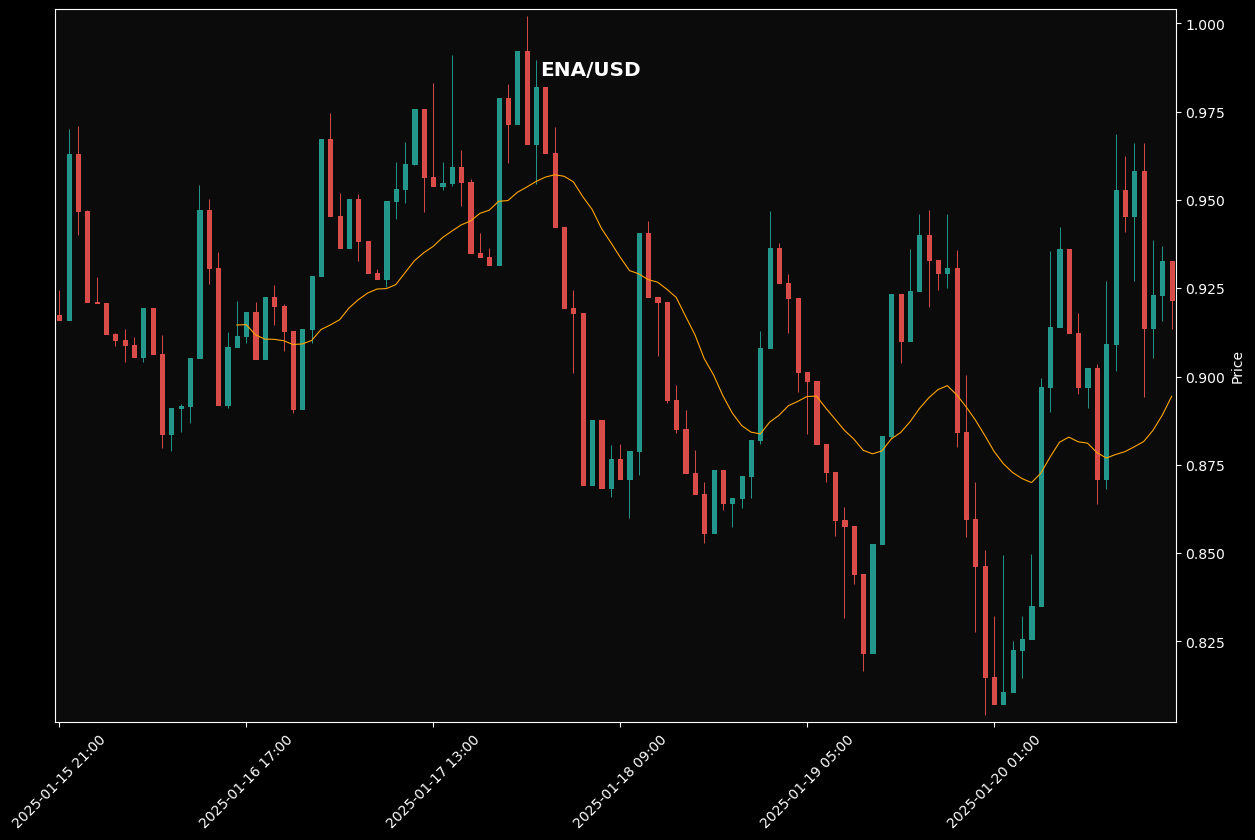

In [1]:
import requests
import pandas as pd
import time
from utils import coinGeckoCandles
from datetime import datetime, timedelta

df = coinGeckoCandles("0xc3db44adc1fcdfd5671f555236eae49f4a8eea18", "eth", "1h", 
                    startDate=datetime.now(), endDate=datetime.now()-timedelta(days=5),
                    limit=100, plotDetails={"plot":True, "type":"mplfinance"})